
# Preprocessing: Mask Adjustments

## 1. Preparations
### 1.1 Install required packages

**!!! ATTENTION !!!**    
Select right Kernel/Environment (with PyTorch installed): `pytorch_env_pyth311`

In [1]:
# check current python version and environment
!python --version
!where python 

Python 3.11.11
c:\Users\simon\anaconda3\envs\pytorch_env_pyth311\python.exe
C:\Users\simon\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# import required packages
import json
import os
import geopandas as gpd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch

### 1.2 Load data

In [7]:
# Data directories
################################################################################
import sys
sys.path.append(os.path.abspath(r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\MoSE_repo"))


# sparse multilabel-encoded maks directory
masks_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\masks"
# additional directories
codes_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\classes"


# output directory
masks_ohe_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\masks_ohe"

In [50]:
# Load class codes
################################################################################
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [51]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

In [52]:
# Add background class to class codes (for One-Hot-Encoding)
################################################################################

label_codes_ohe = label_codes
# Add the background class
label_codes_ohe["Hintergrund"] = 0

# Save the updated label codes back to the file
# path
label_codes_ohe_path = os.path.join(codes_dir, "label_codes_ohe.json")
with open(label_codes_ohe_path, "w") as json_file:
        json.dump(label_codes_ohe, json_file, indent=4)

print(label_codes_ohe) 


{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9, 'Hintergrund': 0}


In [54]:
# reversed dictionary
reversed_label_codes_ohe = {v: k for k, v in label_codes_ohe.items()} # v = value, k = key
reversed_label_codes_ohe[0]

'Hintergrund'

In [10]:
################################################################################
# Load masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
# masks_list

Shape of the mask: (9, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


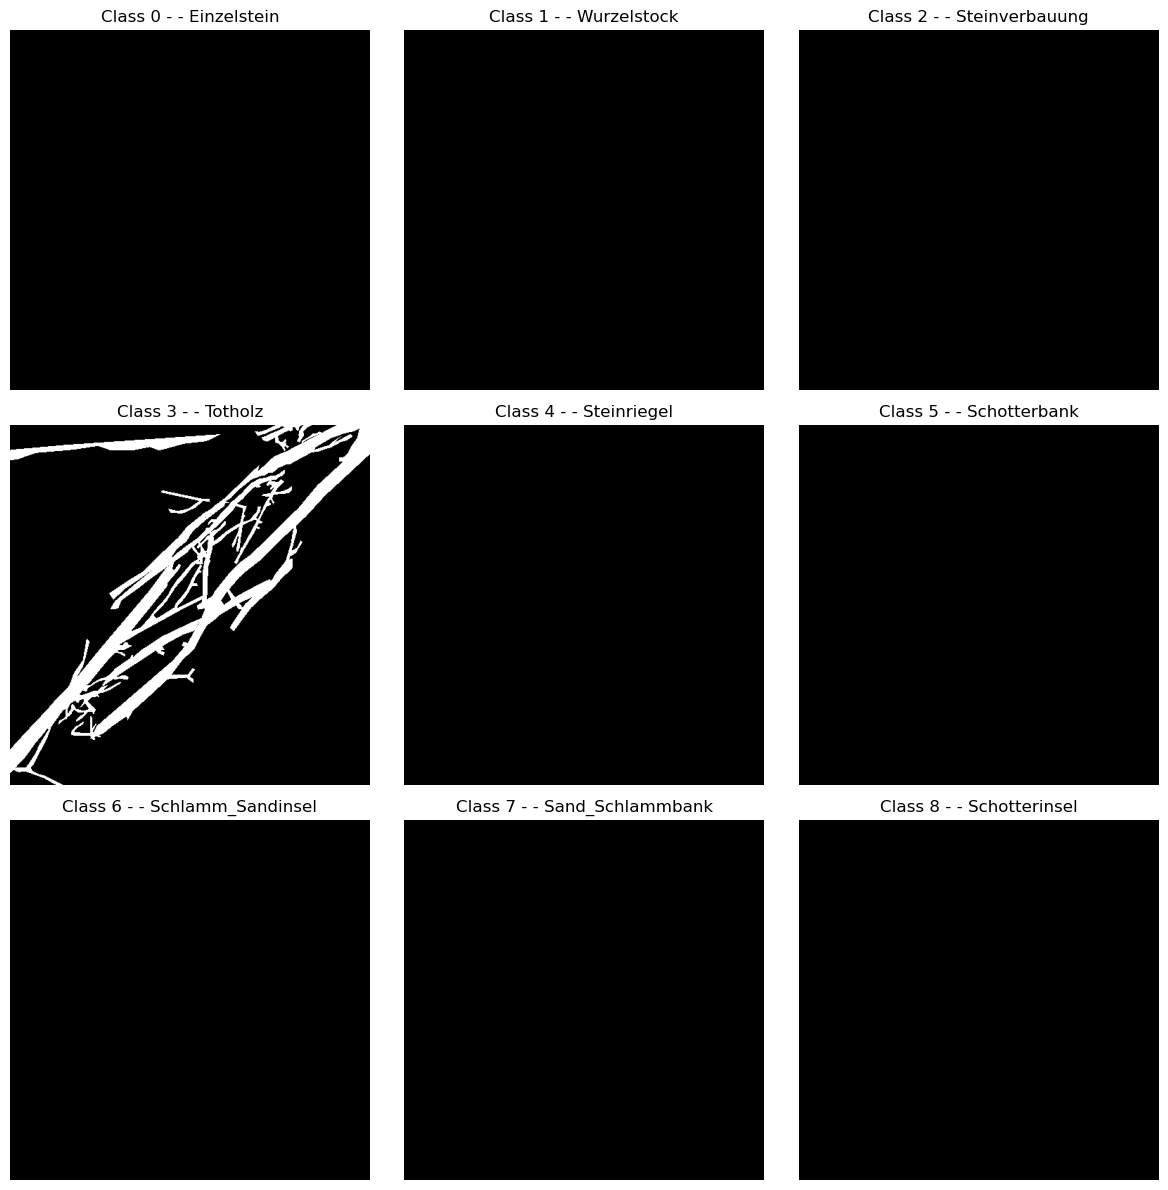

In [26]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 1054 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 9 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

# 2. One-Hot-Encoding

Current masks are not one-hot-encoded, but sparse multilabel encoded (resp. multilabel binary representation). 
Short explanation with an example:

1) Sparse Multilabel Encoding

> Channel 1: 0 0 1  
> Channel 2: 0 0 0   
> Channel 3: 0 1 1   
> = Sum of all channels per pixel can be 0 or bigger than 1. A pixel can be assigned to no class (background) or more than one class.     

Advantages:
Efficient for sparse labels: This representation is well suited if the background (or empty areas) occurs frequently, as memory is saved by not explicitly modeling the background.
Flexibility: This representation allows a pixel to belong to none or several classes at the same time (which can be useful for overlap).

Disadvantages:
Customize loss function: Classic loss functions like CrossEntropyLoss, which assume one-hot encoding, do not work directly here because they expect an explicit background or clear class assignment per pixel. Instead, DiceLoss or BCEWithLogitsLoss are more suitable for your representation.
Interpret performance: The background class is not modeled directly here, which can make it difficult to evaluate model performance (e.g. how well the model separates the background).

2) One-Hot-Encoding

> Channel 1: 0 0 1   
> Channel 2: 1 0 0   
> Channel 3: 0 1 0   
> = Sum of all channels per pixel has to be always 1. A pixel is always assigned to exactly one class (background class has its own channel)!   

In [12]:
def convert_to_one_hot_encoded_masks(masks_dir, masks_ohe_dir):
    """
    Converts Sparse Multilabel Masks to One-Hot-Encoded Masks with a background class.

    Args:
        masks_dir (str): Path to the directory containing sparse multilabel masks.
        output_dir (str): Path to the directory to save one-hot-encoded masks.
    """
    
    masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # List of all masks
    masks_list.sort()  # Sort list alphabetically

    for mask_name in masks_list:
        # Load mask
        mask_path = os.path.join(masks_dir, mask_name)
        mask = np.load(mask_path)  # Shape: (9, 512, 512)

        # Check for conflicts (pixels belonging to multiple classes)
        conflict_mask = mask.sum(axis=0) > 1  # Shape: (512, 512), True for conflicting pixels

        # Create new mask with an extra channel for the background
        one_hot_mask = np.zeros((10, mask.shape[1], mask.shape[2]), dtype=np.uint8)  # Shape: (10, 512, 512)

        # Assign background class
        one_hot_mask[0] = conflict_mask | (mask.sum(axis=0) == 0)  # Background = conflicts or no class

        # Assign the remaining classes
        one_hot_mask[1:] = mask

        # Remove conflicting pixel assignments from all other classes
        one_hot_mask[1:] *= ~conflict_mask  # Set other class values to 0 if pixel is in conflict

        # Save the new mask
        output_path = os.path.join(masks_ohe_dir, mask_name)
        np.save(output_path, one_hot_mask)

    print(f"Converted masks saved to: {masks_ohe_dir}")


In [13]:
convert_to_one_hot_encoded_masks(masks_dir, masks_ohe_dir)

Converted masks saved to: C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\masks_ohe


In [14]:
################################################################################
# Load one-hot-encoded masks
################################################################################

masks_ohe_list = [f for f in os.listdir(masks_ohe_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_ohe_list.sort() # sort list alphabetically
# masks_list

Shape of the mask: (10, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


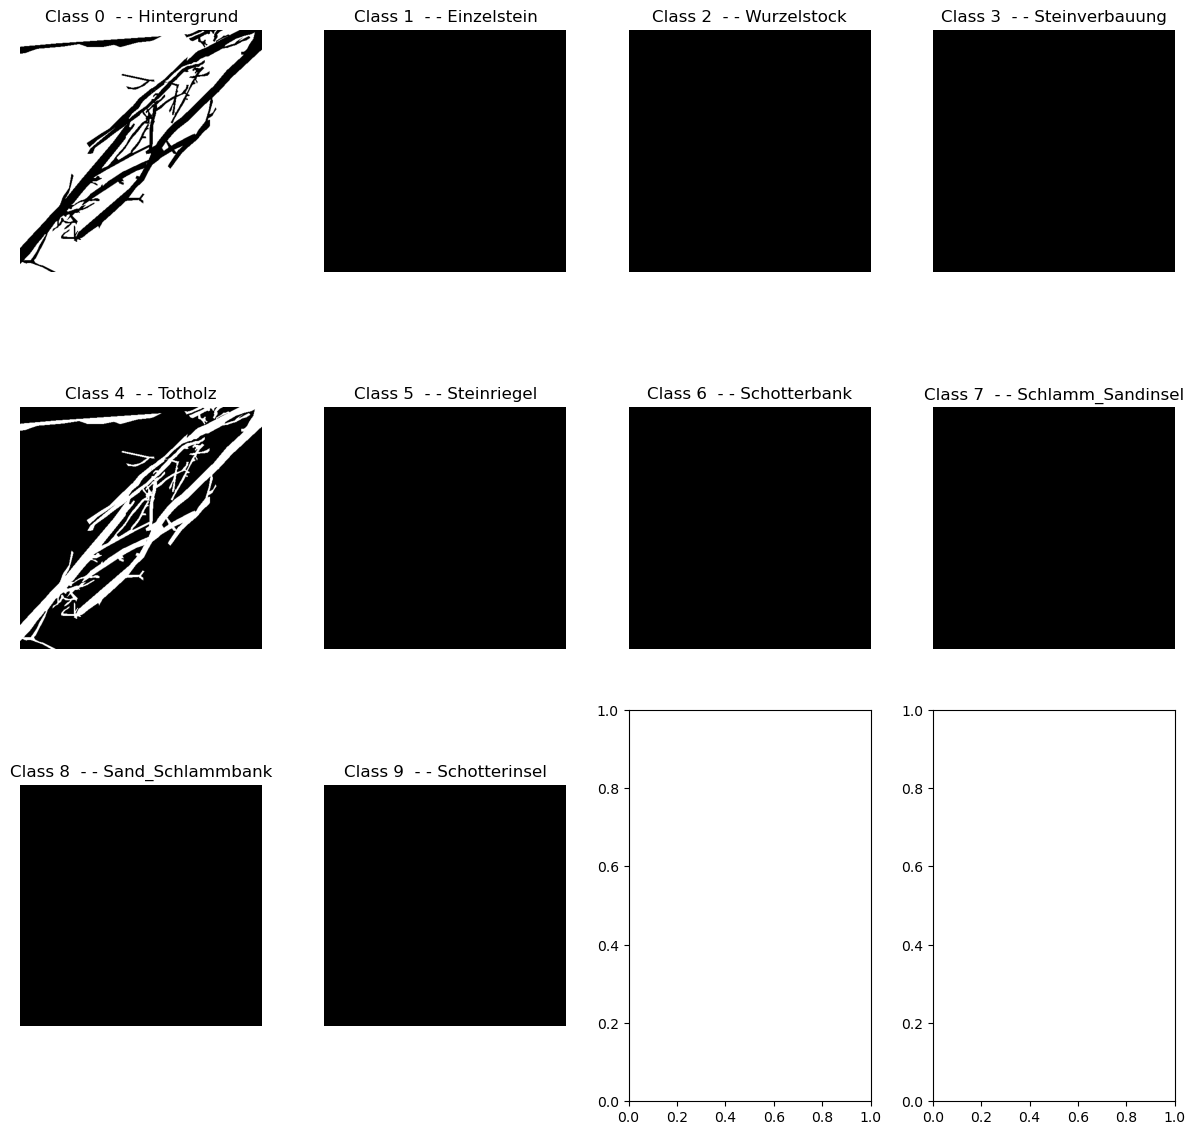

In [55]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 1054 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_ohe_path = masks_ohe_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask_ohe = np.load(test_mask_ohe_path)

# Show properties of the mask
print("Shape of the mask:", test_mask_ohe.shape)
print("Datatype:", test_mask_ohe.dtype)
print("Type:", type(test_mask_ohe))
print("Minimum value:", np.min(test_mask_ohe))
print("Maximum value:", np.max(test_mask_ohe))
print("Unique values:", np.unique(test_mask_ohe)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 4, figsize=(12, 12))  # 4x3 grid (for 10 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask_ohe.shape[0]):  # iterate through the 10 classes
  axes[i].imshow(test_mask_ohe[i], cmap="gray")
  axes[i].set_title(f"Class {i}  - - {reversed_label_codes_ohe[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()